# Data Science Project: Chess Game Analysis
###### by Nakul Iyer

This notebook analyzes a chess dataset It was downloaded from [https://www.kaggle.com/datasnaek/chess](https://www.kaggle.com/datasnaek/chess).

## Standard Import Statements

These are some standard import statements. We'll use numpy and pandas to handle our data, matplotlib to visualize data, and sklearn for the machine learning part of the analysis.

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression

%matplotlib inline

plt.style.use('fivethirtyeight')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10

## Loading the Dataset

In [48]:
csv = pd.read_csv('chess_games.csv')
original_df = pd.DataFrame(csv)

original_df.head(1)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5


The dataset represents a list of chess games played on [https://www.lichess.org](https://www.lichess.org). The output of the dataset is winner, which is either represented as white, black, or draw. Additionality, another possible output is the end game type (I don't intend to use this as an output, though), which can be draw, out of time, mate, or resign. The list of features I initially had access to were:
* **rated**: whether or not the game is rated, as a boolean
* **created_at**: time of the game creation (**_unused_**)
* **last_move_at**: time of the last move (**_unused_**)
* **turns**: number of turns in the game
* **victory_status**: out of time, resign, draw, or mate (**_unused_**)
* **increment_code**: timing of the game (i.e. 10+2 means each player has 10 minutes in total, and after each move, a 2 second addition to the player's timer is made) (**_unused_**)
* **white_id**: name of white player (**_unused_**)
* **white_rating**: rating of white player
* **black_id**: name of black player (**_unused_**)
* **black_rating**: rating of black player
* **moves**: a list of moves (**_unused_**)
* **opening_eco**: name of the opening as a standardized notation
* **opening_name**: name of the opening (**_unused_**)
* **opening_ply**: number of turns in the opening

And the output was:
* **winner**: winner of the game, can either be White, Black, Draw

## Modifying the Dataset

First, we'll drop the following columns:
* id: unimportant for our analysis
* rated: unimportant for our analysis
* created_at: unimportant for our analysis
* last_move_at: unimportant for our analysis
* white_id: unimportant for our analysis
* black_id: unimportant for our analysis
* opening_name: we have opening_eco, which is an easier and equally reliable way of identifying openings
* victory_status: we are not analyzing the type of victory (resign, draw, mate, or out of time)

In [49]:
df = original_df.drop(['id', 'rated', 'created_at', 'last_move_at', 'increment_code',
                       'white_id', 'black_id', 'opening_name', 'victory_status'], 1)

Next, we'll view some stastistic on the data to make sure there's no missing data, and also view the statistics of some of the variables for later use.

In [50]:
df.describe()

,turns,white_rating,black_rating,opening_ply
count,20058.000000,20058.000000,20058.000000,20058.000000
mean,60.465999,1596.631868,1588.831987,4.816981
std,33.570585,291.253376,291.036126,2.797152
min,1.000000,784.000000,789.000000,1.000000
25%,37.000000,1398.000000,1391.000000,3.000000
50%,55.000000,1567.000000,1562.000000,4.000000
75%,79.000000,1793.000000,1784.000000,6.000000
max,349.000000,2700.000000,2723.000000,28.000000


## Graphing the Dataset

Now, let's make histograms of some of the numerical features to gain insight into the distribution of these features. This may also show us some interesting statistics of the games that we may be able to take advantage of.

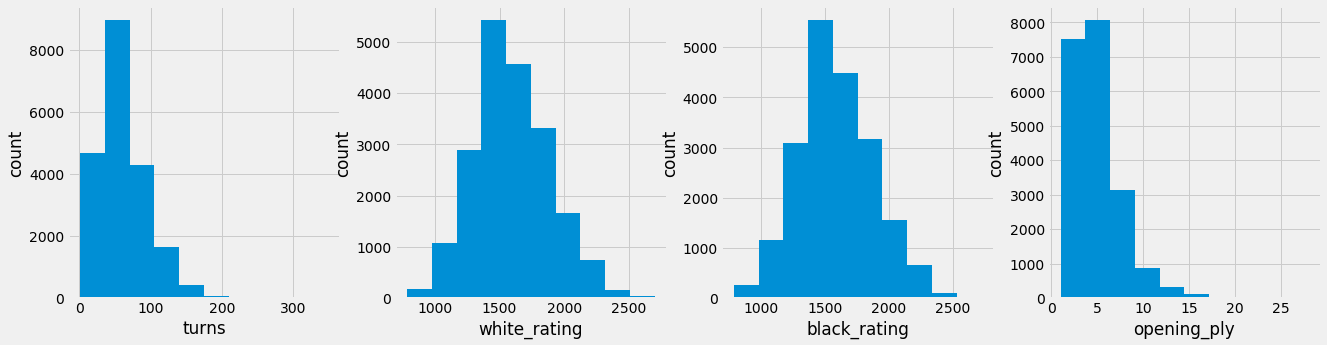

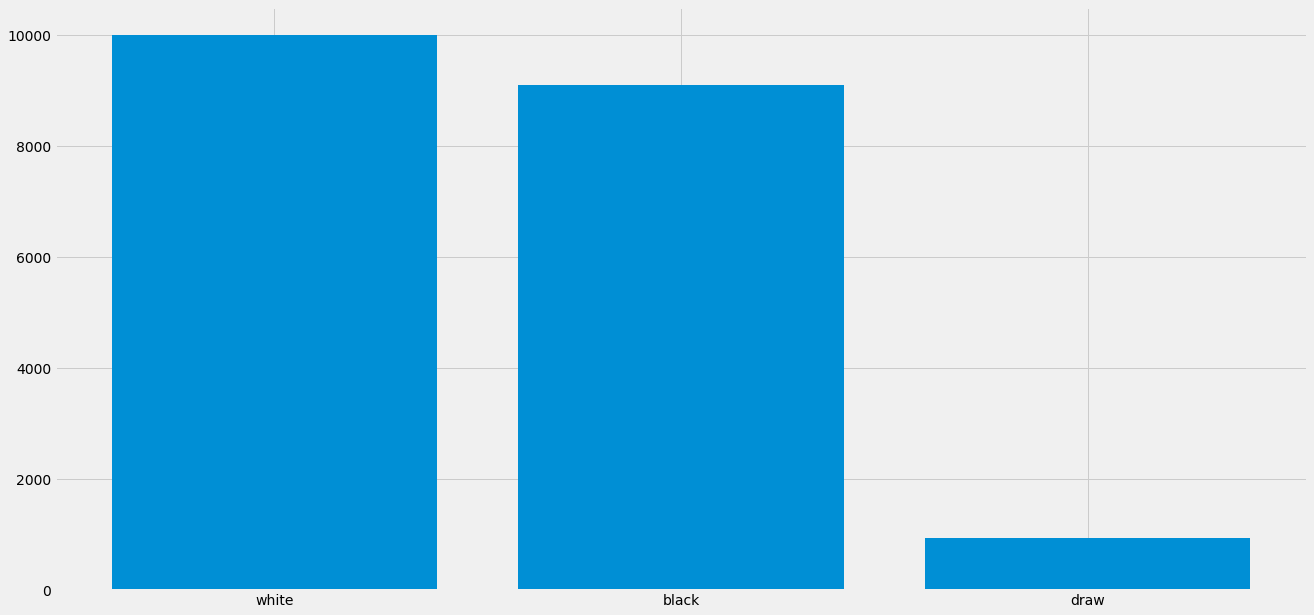

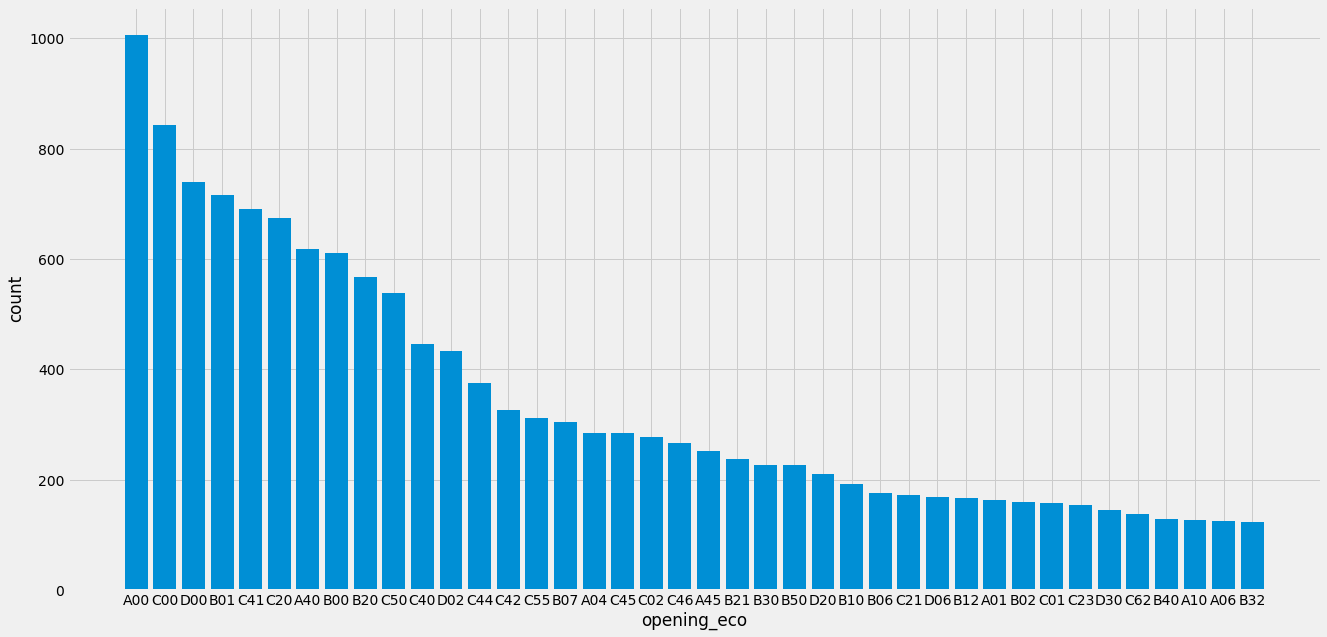

In [56]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

plot_num = 0
for feature in ['turns', 'white_rating', 'black_rating', 'opening_ply']:
    ax[plot_num].hist(df[feature])
    ax[plot_num].set_xlabel(feature)
    ax[plot_num].set_ylabel('count')
    plot_num +=1

plt.show()

plt.bar(df['winner'].value_counts().keys(), df['winner'].value_counts())
plt.show()

most_popular_openings = np.array(df['opening_eco'].value_counts()[:40].keys())
most_popular_openings_counts = np.array(df['opening_eco'].value_counts()[:40])
plt.bar(most_popular_openings, most_popular_openings_counts)
plt.xlabel('opening_eco')
plt.ylabel('count')

plt.show()

Firstly, white_rating and black_rating are nicely normally distributed (a little skewed to the right), so we should actually use these two variables to predict a winner. turns and opening_ply start off increasing, but then quickly decrease, which is to be expected for the turn count and opening_ply. A little more games are won by white, but on the average, white and black win about the same number of games, with a few draws.

Our most interesting claims can come from opening_eco. Many games use only a handful of different openings (A00, C00, D00, B01, C41, C20, A40, B00, B20, and C50). Few games account for the remaining many openings. The distribution seems to follow a power law (reminiscent of [Ziph's Law](https://en.wikipedia.org/wiki/Zipf%27s_law)). This shows us that if we analyze a few openings and see their effectiveness, that should account for most of the games played. Since there are too many openings to analyze all of them one-by-one, we should analyze the most popular 40 or so, and assume that since they account for the most games, they must have been naturally selected as the best openings to play. Hence the other openings would be considered "not important" enough to analyze.

Let's also graph white_rating vs black_rating, are color the graph by white wins. We saw that these variables are evenly distributed, but we might want to see how these ratings affect an outcome. We should expect that if white has a high rating and black has a low rating, white will win. Conversely, if black has a high rating but white has a low rating, white will lose. We want to see exactly where the overlap is.

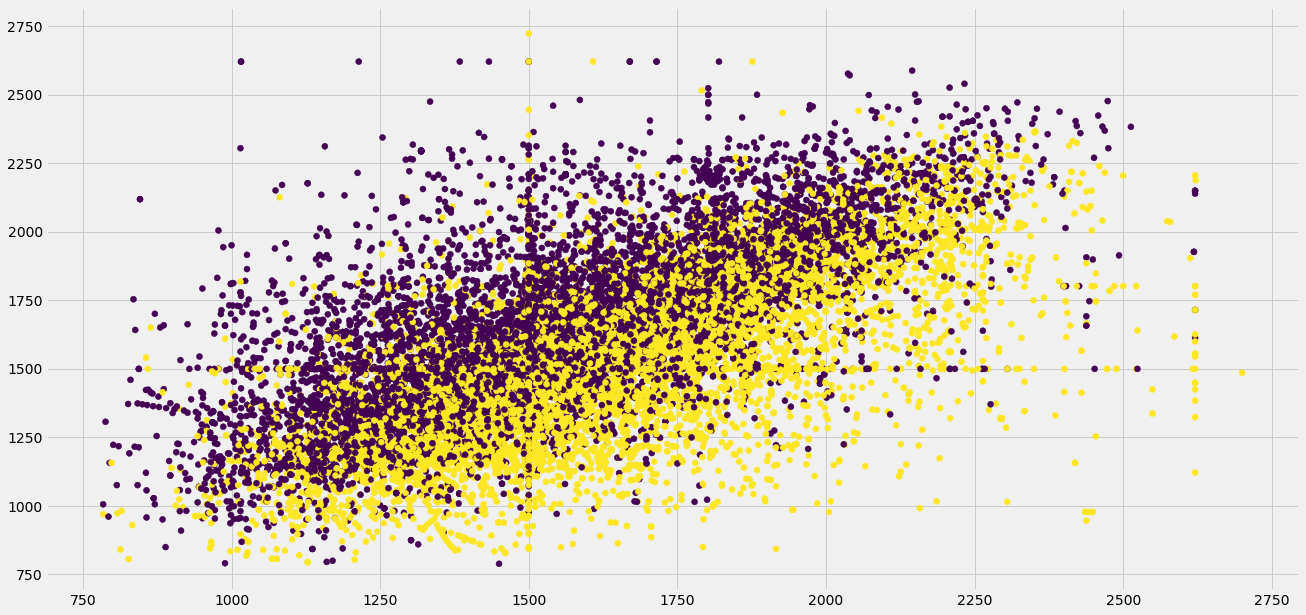

In [54]:
white_wins = df['winner'] == 'white'
plt.scatter(df['white_rating'], df['black_rating'], c=white_wins)
plt.show()

This shows us that our hypothesis is mostly true. Actually, a high rated white rarely plays a low-rated black, and vise versa. This is interesting, since we won't have to consider a problem like that (where two players with vastly different abilities are playing each other). This gives us just what we want to see; rating difference is a fair predictor of outcome, but is not really all too effective when the difference is small. Hence, it will be good to fit in a model, amongst other features.

## Preprocessing

Let's define some functions that will be super useful later. These are for the preprocessing of our "moves" feature.

In [57]:
def get_every_second(s, w_b):
    '''
        This method splits a string s into a list by spaces,
        and returns every other entry in that list as another
        list, beginning with w_b. It is used to break the string
        into lists for white moves and black moves
    '''
    
    spl = s.split(' ')
    return [spl[i] for i in range(w_b, len(spl), 2)]

def search_in_moves(s, typ, moves, play_length=0, MOVE_THRESHOLD=10):
    '''
        This method searches for a string s in the list called
        moves. We can search in different areas of the moveset
        by setting typ as 0 for opening, 1 for mid-game, 2 
        for end-game, and 3 for total (all occurances). 
        play_length specifies the length of moves we're
        searching. MOVE_THRESHOLD is set such that if a game length
        is smaller than the MOVE_THRESHOLD, it will be considered
        that there is no endgame at all.
    '''
    
    if typ == 0:
        return sum([move.count(s) for move in moves[0:play_length]])
    elif typ == 1:
        if len(moves) < MOVE_THRESHOLD:
            return sum([move.count(s) for move in moves[play_length:]])
        return sum([move.count(s) for move in moves[play_length:int(len(moves)*0.6)]])
    elif typ == 2:
        if len(moves) < MOVE_THRESHOLD:
            return 0
        return sum([move.count(s) for move in moves[int(len(moves)*0.6):]])
    return sum([move.count(s) for move in moves])

def create_features(df, search_term, prefix, totals=False):
    '''
        Given a dataframe df, a string search_term, and
        a string prefix, this method will append several new
        features to the df using the search_in_move method called
        with a search term search_term. prefix is used to name
        these new features.
    '''
    
    df['white_opening_' + prefix] = df[['white_moves', 'opening_ply']].apply(lambda x: search_in_moves(search_term, 0, *x), axis=1)
    df['black_opening_' + prefix] = df[['black_moves', 'opening_ply']].apply(lambda x: search_in_moves(search_term, 0, *x), axis=1)

    df['white_midgame_' + prefix] = df[['white_moves', 'opening_ply']].apply(lambda x: search_in_moves(search_term, 1, *x), axis=1)
    df['black_midgame_' + prefix] = df[['black_moves', 'opening_ply']].apply(lambda x: search_in_moves(search_term, 1, *x), axis=1)

    df['white_endgame_' + prefix] = df[['white_moves', 'opening_ply']].apply(lambda x: search_in_moves(search_term, 2, *x), axis=1)
    df['black_endgame_' + prefix] = df[['black_moves', 'opening_ply']].apply(lambda x: search_in_moves(search_term, 2, *x), axis=1)
    
    if totals:
        df['white_total_' + prefix] = df['white_moves'].map(lambda moves: search_in_moves(search_term, 3, moves))
        df['black_total_' + prefix] = df['black_moves'].map(lambda moves: search_in_moves(search_term, 3, moves))

Now, we'll start to parse the large "moves" feature (containing the set of moves written in standard chess notation) into small features. We'll start with the numerical ones.

First, we'll start with splitting the moves for each player 

In [58]:
df['white_moves'] = df['moves'].map(lambda s: get_every_second(s, 0))
df['black_moves'] = df['moves'].map(lambda s: get_every_second(s, 1))

Now, we'll parse the data for pieces captured.

In [59]:
create_features(df, 'x', 'pieces_captured', totals=True)

Now, let's parse data for checks in a very similar fashion. Importantly, these new features refer to CHECKS GIVEN, not checks received!!!

In [60]:
create_features(df, '+', 'checks_given', totals=True)

Lastly, we'll check promotions.

In [61]:
df['white_total_promotions'] = df['white_moves'].map(lambda moves: search_in_moves('=', 3, moves))
df['black_total_promotions'] = df['black_moves'].map(lambda moves: search_in_moves('=', 3, moves))

Next, let's check the number of times each piece moved. We'll check every piece but pawns; pawns don't have a notation (you just put in the square it moved to, like d4 for a pawn instead of Bd4 for a bishop), so it's hard to check this. Also, the number of pawn moves isn't all too important.

This block of code does take some time (~20s) to load, but we get a ton of useful features from it.

In [62]:
pieces = ['K', 'Q', 'N', 'R', 'B']

for piece in pieces:
    create_features(df, piece, piece + '_moved')

Now, let's do more categorical features. Castling?

In [63]:
create_features(df, 'o-o', 'kingside_castle')
create_features(df, 'o-o-o', 'queenside_castle')

### Openings

Let's first see how many openings there are

In [64]:
print('There are', len(df['opening_eco'].unique()), 'openings')
df['opening_eco'].head()

There are 365 openings


0    D10
1    B00
2    C20
3    D02
4    C41
Name: opening_eco, dtype: object

It's listed as a set of opening eco codes (More information [here](https://www.365chess.com/eco.php)). There are too many to one-hot encode all of them. So, we'll one hot encode the most popular 40 openings.

In [67]:
most_popular_openings = df['opening_eco'].value_counts()[:40].keys()
for opening in most_popular_openings:
    df[opening] = df['opening_eco'] == opening

Now let's just check how many columns we have.

In [71]:
print(len(df.columns.values))
print(df.columns.values[:20], '...')

109
['turns' 'winner' 'white_rating' 'black_rating' 'moves' 'opening_eco'
 'opening_ply' 'white_moves' 'black_moves' 'white_opening_pieces_captured'
 'black_opening_pieces_captured' 'white_midgame_pieces_captured'
 'black_midgame_pieces_captured' 'white_endgame_pieces_captured'
 'black_endgame_pieces_captured' 'white_total_pieces_captured'
 'black_total_pieces_captured' 'white_opening_checks_given'
 'black_opening_checks_given' 'white_midgame_checks_given'] ...


## Graphing our Preprocessing

Before we continue with the data processing, let's first graph the result of our preprocessing. We'll assume that black follows the same trends as white for this.

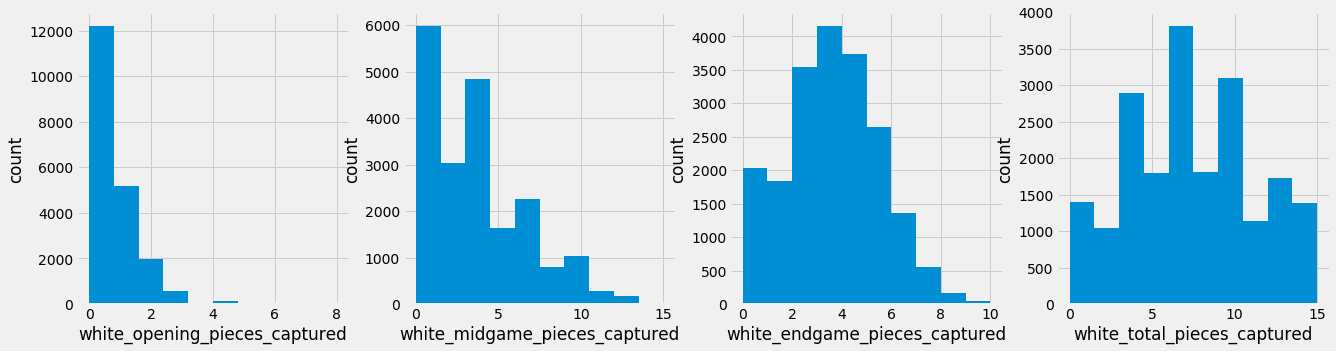

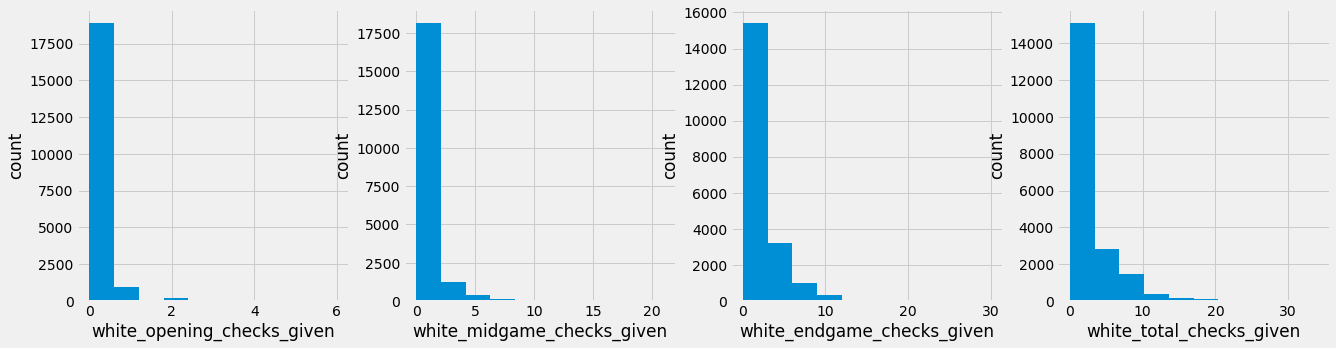

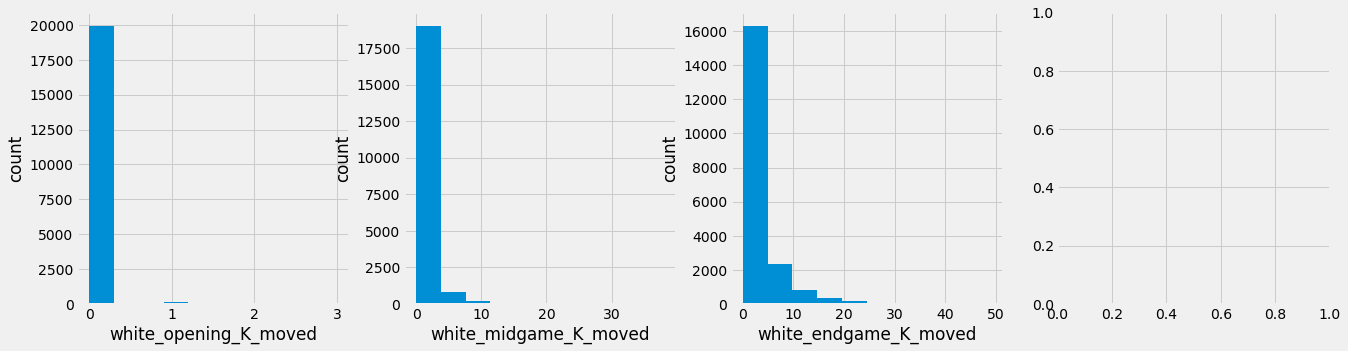

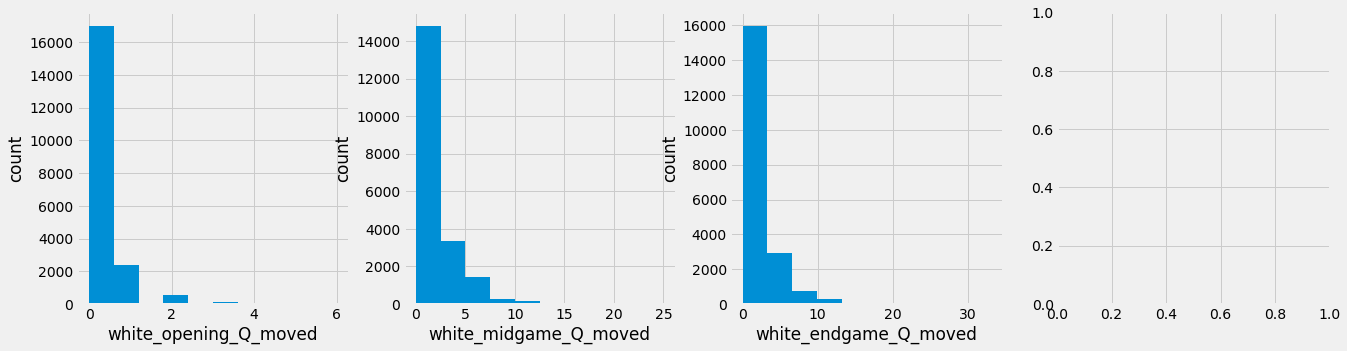

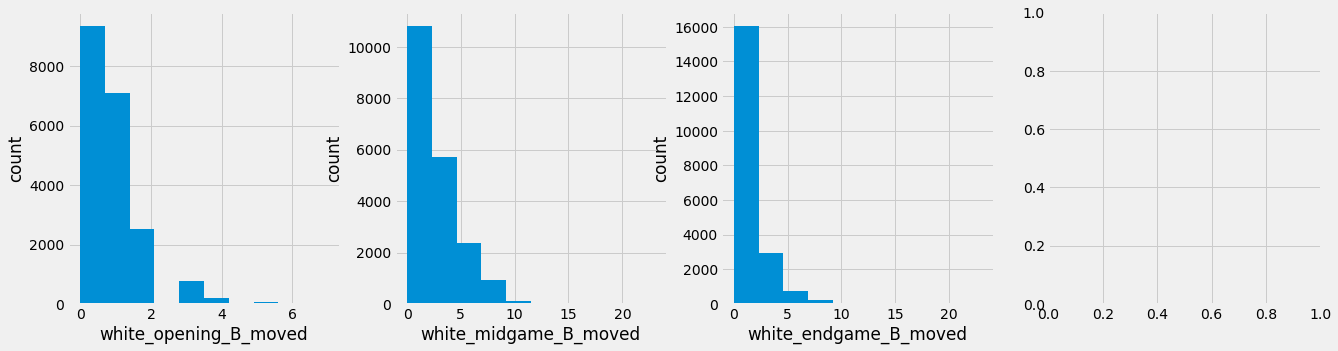

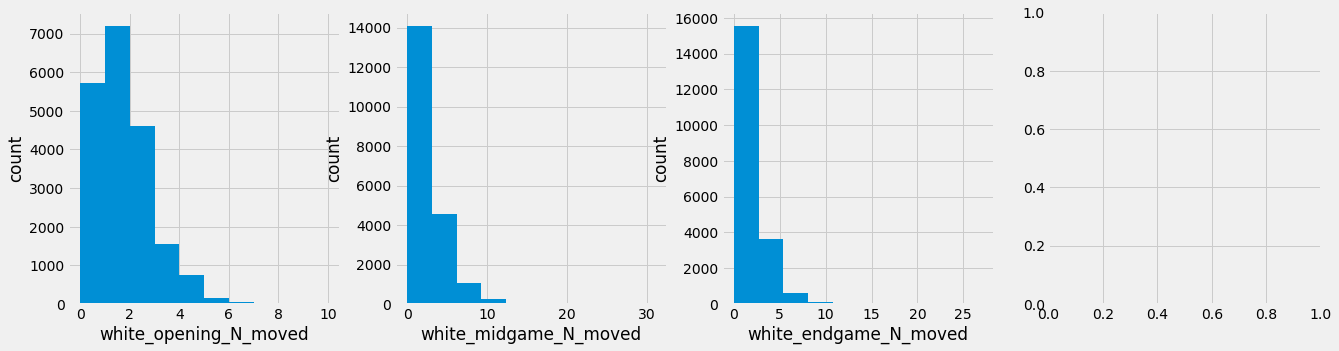

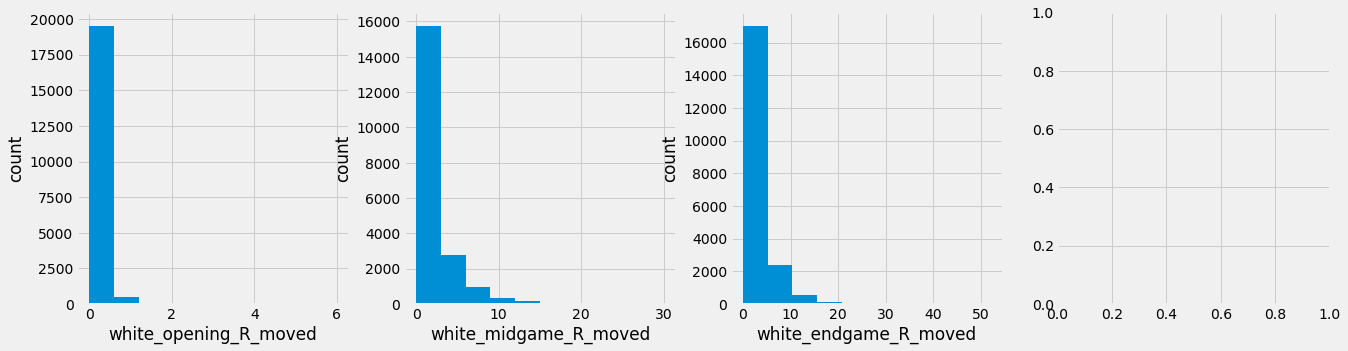

In [84]:
typs = ['opening', 'midgame', 'endgame', 'total']

for feature in ['pieces_captured', 'checks_given', 'K_moved', 'Q_moved', 'B_moved', 'N_moved', 'R_moved']:
    plot_num = 0
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    for typ in typs:
        try:
            ax[plot_num].hist(df['white_' + typ + '_' + feature])
            ax[plot_num].set_xlabel('white_' + typ + '_' + feature)
            ax[plot_num].set_ylabel('count')
        except:
            pass
        plot_num += 1
    plt.show()

As a sanity check, it looks like all the graphs show a little variance between opening, mid-game, and end-game, but not too much.

In [127]:
train = df[:int(len(df) * 0.7)]
cross_valid = df[int(len(df) * 0.7):int(len(df) * 0.8)]
test = df[int(len(df) * 0.8):]

print("length of train is ", len(train))
print("length of cross valid is ", len(cross_valid))
print("length of test is ", len(test))

length of train is  14040
length of cross valid is  2006
length of test is  4012


### Predicting

Let's clean up the features a bit. These are features we don't need:
* winner: it's the output
* moves: we've already preprocessed this, and it's unimportant now
* opening_eco: we've already preprocessed this, and it's unimportant now
* white_moves: it's a list, and we've preprocessed it
* black_moves: it's a list, and we've preprocessed it

In [112]:
features = np.array(df.columns.values)
features = np.delete(features, [1,4,5,7,8])

Now, let's apply our learning algorithms. Clearly, we want to use supervised learning; we have a clear output (winner) and clear features. We are trying to predict, from the state of a game, who will win; by doing this, we can then test which openings/other moves are best.

We will use [Random Forest Classification](https://en.wikipedia.org/wiki/Random_forest) to determine the winner of a game. Given that we have several features, this will allow us to see which features are the most important, and it will use these importances to predict a winner.

In [113]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(train[features], train['winner'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [114]:
feature_importances = model.feature_importances_

result = pd.DataFrame()
result['features'] = features
result['importances'] = feature_importances

pd.set_option('display.max_rows', len(result))
result

,features,importances
0,turns,0.037441
1,white_rating,0.046680
2,black_rating,0.047118
3,opening_ply,0.018561
4,white_opening_pieces_captured,0.007664
5,black_opening_pieces_captured,0.008697
6,white_midgame_pieces_captured,0.020107
7,black_midgame_pieces_captured,0.021607
8,white_endgame_pieces_captured,0.050678
9,black_endgame_pieces_captured,0.053355


## First Conclusions

From Random Forest Classification, we can see some clear trends from this long output. First off, whether or not we castle or which side we castle on seems irrelevant to most games. This is probably because both sides generally castle in game, and castling at the begining or end of a game isn't too different. 
Additionally, it's hard to predict the result from the opening, but some openings certainly perform better for either side. The amount of times each pieces moved in each part of the game is also surprisingly useful.

On the whole, though, each of the feature_importances are less than 0.1, which means that none of the features are useful on their own to predict an outcome. Fortunately, Random Forest Classification can help us find good fits for an input given that we have so many features.

## Cross Validation

This part is pretty long. It's not necessary to run most of this stuff; the conclusions drawn from this section are used to tune the actual RandomForestClassifier in the next section.

In [128]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier()
model.fit(train[features], train['winner'])

print('Train accuracy score (useless):', accuracy_score(model.predict(train[features]), train['winner']))
print('Cross validation accuracy score (useful):', accuracy_score(model.predict(cross_valid[features]), cross_valid['winner']))

Train accuracy score (useless): 0.99002849002849
Cross validation accuracy score (useful): 0.7941176470588235


It's obvious that our model is over-fitting a **ton**. So, let's play around with some of the variables in RandomForestClassifier. Particularly, these features:
* n_estimators (the number of trees)
* max_depth (maximum depth of the trees)
* min_samples_split (minimum samples needed to split a node)
* min_samples_leaf (minimum samples needed for a leaf to be considered important enough to be its own).

Specifically, here's what we'll do:
* n_estimators just gets better as it grows larger, so we'll set it to 200
* max_depth: we should play around with different values of this ranging from 10 to 100
* min_samples_split: we should play around with just a few values of this (1 through 5 or so) to see if it's effective
* min_samples_leaf: same for min_samples_split

In [148]:
depths = [10, 20, 40, 80, 160, None]
train_scores = []
cv_scores = []
for depth in depths:
    model = RandomForestClassifier(max_depth=depth)
    model.fit(train[features], train['winner'])
    train_scores.append(accuracy_score(model.predict(train[features]), train['winner']))
    cv_scores.append(accuracy_score(model.predict(cross_valid[features]), cross_valid['winner']))

In [149]:
cvs = pd.DataFrame()
cvs['depths'] = depths
cvs['train_scores'] = train_scores
cvs['cv_scores'] = cv_scores
cvs

,depths,train_scores,cv_scores
0,10.0,0.841026,0.761715
1,20.0,0.982336,0.782652
2,40.0,0.990171,0.770189
3,80.0,0.989459,0.783649
4,160.0,0.990313,0.782154
5,NaN,0.991026,0.784148


Our best value of depth seems to be around 20. Now let's test min_samples_split

In [157]:
mss = [2, 5, 8, 10, 15]
train_scores = []
cv_scores = []
for ms in mss:
    model = RandomForestClassifier(max_depth=20, min_samples_split=ms)
    model.fit(train[features], train['winner'])
    train_scores.append(accuracy_score(model.predict(train[features]), train['winner']))
    cv_scores.append(accuracy_score(model.predict(cross_valid[features]), cross_valid['winner']))

In [158]:
cvs = pd.DataFrame()
cvs['mean_sample_splits'] = mss
cvs['train_scores'] = train_scores
cvs['cv_scores'] = cv_scores
cvs

,mean_sample_splits,train_scores,cv_scores
0,2,0.982407,0.786142
1,5,0.958048,0.783649
2,8,0.940883,0.785145
3,10,0.929558,0.785643
4,15,0.906553,0.785643


min_samples_split hits a peak performance when it equals 10. It also quickly decreases the train_scores, which is very good. Now, let's do the same for min_samples_leaf.

In [161]:
msl = [2, 5, 8, 10, 15]
train_scores = []
cv_scores = []
for ms in msl:
    model = RandomForestClassifier(max_depth=20, min_samples_split=10, min_samples_leaf=ms)
    model.fit(train[features], train['winner'])
    train_scores.append(accuracy_score(model.predict(train[features]), train['winner']))
    cv_scores.append(accuracy_score(model.predict(cross_valid[features]), cross_valid['winner']))

In [162]:
cvs = pd.DataFrame()
cvs['mean_sample_leaves'] = msl
cvs['train_scores'] = train_scores
cvs['cv_scores'] = cv_scores
cvs

,mean_sample_leaves,train_scores,cv_scores
0,2,0.909900,0.786142
1,5,0.881909,0.782652
2,8,0.852849,0.778166
3,10,0.838604,0.786142
4,15,0.820726,0.770189


min_samples_leaf works well enough at 2. Now, let's test our data.

## Testing

In [171]:
model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=2, min_samples_leaf=2)
model.fit(train[features], train['winner'])

accuracy_score(model.predict(test[features]), test['winner'])

0.78938185443669

This is a fairly decent accuracy score for this kind of prediction (the outcome of a chess game is very random, so nearly an 80% accuracy means that our features were chosen quite well).

Now, let's graph.

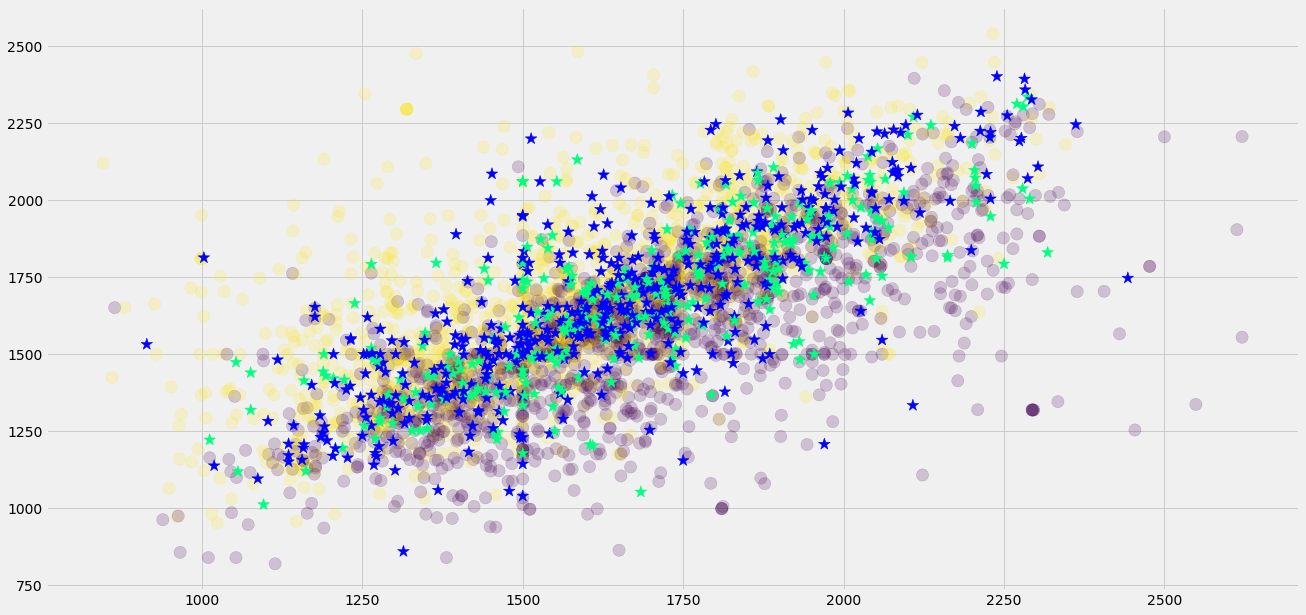

In [206]:
predicts = model.predict(test[features])

corrects = test[predicts==test['winner']]
incorrects = test[predicts!=test['winner']]

plt.scatter(corrects['white_rating'], corrects['black_rating'], c=corrects['winner']=='white', 
            cmap='viridis_r', alpha=0.2, s=150.0, marker='o')
plt.scatter(incorrects['white_rating'], incorrects['black_rating'], c=incorrects['winner']=='white', 
            cmap='winter', alpha=1.0, s=150.0, marker='*')
plt.show()

Interpretation of this graph:
* Low alpha purples are true negatives
* Low alpha yellows are true positives
* Star blues are false positives
* Star greens are false negatives

Our graph shows us that the any failure in our predictions is out of the randomness of the game. Most of the errors occur where the ratings of white and black are close.